In [2]:
# Install missing packages if needed
!pip install tensorflow opencv-python matplotlib pillow tensorflow-datasets

In [2]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [7]:
try:
    # Config
    BATCH_SIZE = 32
    IMG_SIZE = (128, 128)
    EPOCHS = 10
    NUM_CLASSES = 101

    # Load dataset
    (train_ds, val_ds), info = tfds.load(
        'food101',
        split=['train', 'validation'],
        as_supervised=True,
        with_info=True,
        download=False
    )

    # Preprocessing
    def preprocess(image, label):
        image = tf.image.resize(image, IMG_SIZE)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Load pretrained MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(128, 128, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    # Build model
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model and capture history
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS
    )

    # Save model
    model.save('modelPhase3.h5')

    # Prepare final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    # Create an image showing metrics
    img = Image.new('RGB', (500, 300), color=(255, 255, 255))
    d = ImageDraw.Draw(img)

    text = (
        f"Training Finished!\n\n"
        f"Train Accuracy: {final_train_acc:.4f}\n"
        f"Val Accuracy: {final_val_acc:.4f}\n"
        f"Train Loss: {final_train_loss:.4f}\n"
        f"Val Loss: {final_val_loss:.4f}"
    )

    d.text((20, 50), text, fill=(0, 0, 0))

    # Save and display the image
    img.save("training_summary.png")
    img.show()

except Exception as e:
    print(e)

print("Model processed")

Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 183s 76ms/step - accuracy: 0.3269 - loss: 2.8858 - val_accuracy: 0.4939 - val_loss: 1.9937
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 169s 71ms/step - accuracy: 0.5088 - loss: 1.9714 - val_accuracy: 0.5024 - val_loss: 1.9743
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 191s 80ms/step - accuracy: 0.5434 - loss: 1.7938 - val_accuracy: 0.5007 - val_loss: 2.0005
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 179s 76ms/step - accuracy: 0.5678 - loss: 1.6798 - val_accuracy: 0.5027 - val_loss: 2.0324
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 173s 73ms/step - accuracy: 0.5839 - loss: 1.6019 - val_accuracy: 0.4949 - val_loss: 2.0971
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 180s 76ms/step - accuracy: 0.5972 - loss: 1.5438 - val_accuracy: 0.4902 - val_loss: 2.1519
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 177s 75ms/step - accuracy: 0.6065 - loss: 1.4991 - val_accuracy: 0.4907 - val_loss: 2.1715
Epoch 8/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 174s 73ms/step - accuracy: 

Model processed


In [10]:
try:
    # Prepare final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    # Create an image showing metrics
    img = Image.new('RGB', (500, 300), color=(255, 255, 255))
    d = ImageDraw.Draw(img)

    text = (
        f"Training Finished!\n\n"
        f"Train Accuracy: {final_train_acc:.4f}\n"
        f"Val Accuracy: {final_val_acc:.4f}\n"
        f"Train Loss: {final_train_loss:.4f}\n"
        f"Val Loss: {final_val_loss:.4f}"
    )
    print(text)
except Exception as e:
    print(e)

# Training Finished!

# Train Accuracy: 0.6324
# Val Accuracy: 0.4821
# Train Loss: 1.3849
# Val Loss: 2.3164

Training Finished!

Train Accuracy: 0.6324
Val Accuracy: 0.4821
Train Loss: 1.3849
Val Loss: 2.3164


Model loaded successfully!
Loaded image from URL.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


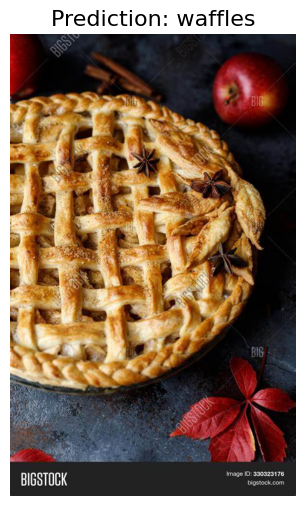

Predicted class ID: 100
Predicted class name: waffles


In [8]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import os

# ─── CONFIG ───────────────────────────────────────────────────────────────────
IMG_SIZE = (128, 128)  # Model expects 128x128 images
NUM_CLASSES = 101     # Food-101 has 101 classes

# Food-101 class names
class_names = [
    'apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare',
    'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito',
    'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake',
    'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla',
    'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder',
    'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes',
    'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots',
    'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries',
    'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt',
    'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon',
    'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros',
    'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich',
    'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette',
    'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta',
    'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib',
    'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto',
    'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese',
    'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi',
    'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles'
]

# ─── LOAD THE MODEL ────────────────────────────────────────────────────────────
model = tf.keras.models.load_model(r'C:\Users\646ca\Downloads\CPP-Spring2025-CS4200-FinalProject\src\model\modelPhase3.h5')
print("Model loaded successfully!")

# ─── FUNCTION TO PREDICT FROM IMAGE PATH OR URL ─────────────────────────────────
def predict_image(image_source):
    try:
        # Check if input is a URL
        if image_source.startswith('http://') or image_source.startswith('https://'):
            response = requests.get(image_source)
            img = Image.open(BytesIO(response.content))
            print("Loaded image from URL.")
        else:
            img = Image.open(image_source)
            print("Loaded image from local path.")

        # # Display the original image
        # img.show()

        # Preprocess for model prediction
        img_resized = img.resize(IMG_SIZE)
        img_array = tf.keras.utils.img_to_array(img_resized)
        img_array = img_array / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]
        predicted_class_name = class_names[predicted_class]

        # Display image
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction: {predicted_class_name}", fontsize=16)
        plt.show()
        
        return predicted_class, predicted_class_name

    except Exception as e:
        print(f"Error processing image: {e}")
        return None

def print_prediction(image_source):
    try: 
        predicted_class, predicted_class_name = predict_image(image_source)
        
        if predicted_class is not None:
            print(f"Predicted class ID: {predicted_class}")
            print(f"Predicted class name: {predicted_class_name}")
        else:
            print("Prediction failed.")
    except Exception as e:
        print(e)

image = 'https://th.bing.com/th/id/OIP.5EJUcpJstOrfXzgRe92G6wHaL_?rs=1&pid=ImgDetMain'
print_prediction(image)

Loaded image from URL.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


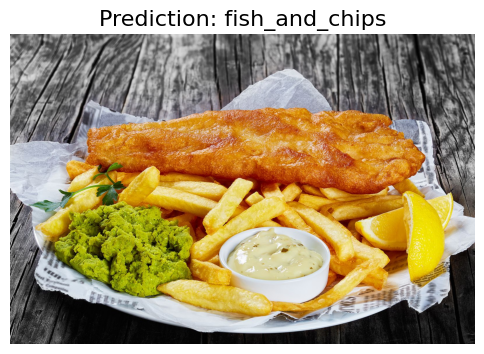

Predicted class ID: 38
Predicted class name: fish_and_chips
Loaded image from URL.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


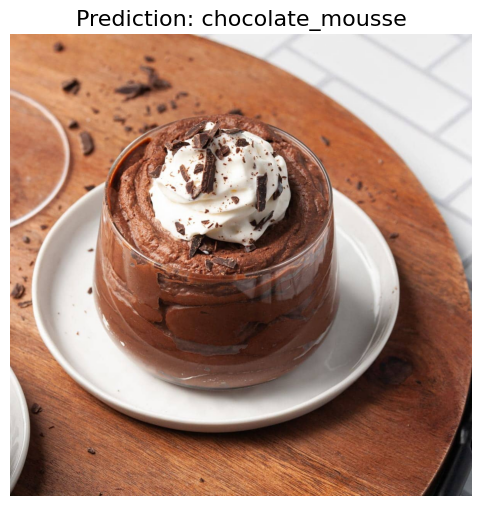

Predicted class ID: 22
Predicted class name: chocolate_mousse


In [10]:
print_prediction("https://cdn.britannica.com/79/234779-050-4B07137B/fish-and-chips-mushy-peas.jpg")
print_prediction("https://marleysmenu.com/wp-content/uploads/2020/04/Boozy-Chocolate-Mousse-Featured-Image-1.jpg")

In [ ]:
import os, tensorflow as tf, tensorflow_datasets as tfds

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "1" 
tf.config.optimizer.set_jit(True) 

import multiprocessing as mp
cores = mp.cpu_count()
tf.config.threading.set_intra_op_parallelism_threads(cores)
tf.config.threading.set_inter_op_parallelism_threads(max(2, cores // 2))

MODEL_SAVE_PATH = 'modelPhase4_optimized.h5'
BATCH_SIZE       = 32
IMG_SIZE         = (256, 256) 
EPOCHS           = 10
FINE_TUNE_EPOCHS = 10
NUM_CLASSES      = 101

def preprocess(img, label):
    img = tf.image.resize(img, IMG_SIZE)
    return tf.cast(img, tf.float32) / 255., label

(train_ds, val_ds), info = tfds.load(
    'food101',
    split=['train', 'validation'],
    as_supervised=True,
    with_info=True,
    download=False
)

train_ds = (train_ds
            .shuffle(1000, reshuffle_each_iteration=True)   # §4
            .cache()
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (val_ds
          .cache()
          .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))

base = tf.keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    alpha=0.5
)
base.trainable = False

model = tf.keras.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.2, patience=3)
]

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=callbacks)

# --- Fine-tune last layers ---
base.trainable = True
for layer in base.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(train_ds,
          validation_data=val_ds,
          epochs=EPOCHS + FINE_TUNE_EPOCHS,
          initial_epoch=history.epoch[-1],
          callbacks=callbacks)

model.save(MODEL_SAVE_PATH)


C:\Users\646ca\AppData\Local\Temp\ipykernel_20652\1887631713.py:43: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


Epoch 1/10
 690/2368 ━━━━━━━━━━━━━━━━━━━━ 3:34 128ms/step - accuracy: 0.0543 - loss: 4.4603

In [4]:
import tensorflow as tf

try:
    # 1) Load your two pretrained models
    m256 = tf.keras.models.load_model('model/modelPhase2.h5')   # outputs shape=(batch, 80)
    m128 = tf.keras.models.load_model('model/modelPhase3.h5')   # outputs shape=(batch,101)
    
    # 2) Master input (dynamic H×W)
    inp = tf.keras.Input(shape=(None, None, 3), name='input_image')
    
    # 3) Resize branches for each model
    b1 = tf.keras.layers.Resizing(256, 256, name='resize_256')(inp)
    b2 = tf.keras.layers.Resizing(128, 128, name='resize_128')(inp)
    
    # 4) Get each model’s predictions
    out1 = m256(b1)   # e.g. puppy-vs-frog head (80-dim)
    out2 = m128(b2)   # e.g. Food-101 head (101-dim)
    
    # 5) Build multi-output Model
    multi = tf.keras.Model(
        inputs=inp,
        outputs=[out1, out2],
        name='multi_output_model'
    )
    
    # 6) Compile (only needed if you plan to fine-tune)
    multi.compile(
        optimizer='adam',
        loss=[
            'sparse_categorical_crossentropy',   # for out1
            'sparse_categorical_crossentropy'    # for out2
        ],
        metrics=['accuracy']
    )
    
    # 7) Save as a single HDF5 file
    multi.save('multi_output_model.h5', save_format='h5')
    print("Exported multi-output model to multi_output_model.h5")

except Exception as e:
    print(e)

Exported multi-output model to multi_output_model.h5


In [4]:
from PIL import Image
import matplotlib.pyplot as plt

def display_image(img):
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

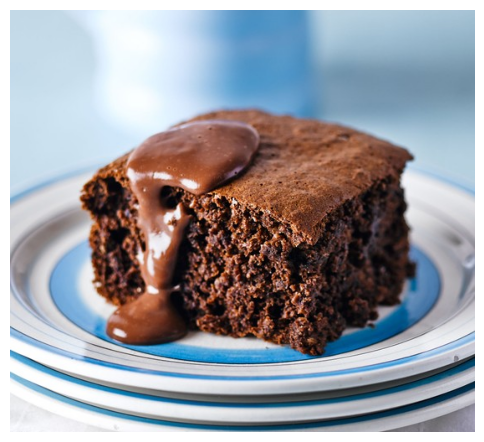

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
COCO-80 head scores   : [[6.15002394e-01 1.06283358e-06 2.74675804e-05 6.00380421e-01
  3.24365465e-11 3.96542743e-10 1.30471378e-07 2.64687673e-03
  3.12228480e-07 4.19920099e-08 1.32170499e-06 1.01327680e-01
  5.25509948e-11 1.95529763e-14 1.83217377e-15 8.84448331e-12
  6.74846568e-11 2.62595434e-02 6.29461094e-10 2.50075777e-06
  9.65896834e-06 2.75640572e-15 5.30055437e-13 4.33454561e-09
  6.43040257e-05 1.65354068e-04 1.48901522e-08 4.24903612e-10
  1.25829418e-08 1.03114544e-07 1.48549684e-09 3.06364445e-09
  3.20438572e-11 7.05035463e-14 3.97452382e-09 1.89914883e-14
  5.97496844e-11 5.19818459e-05 1.60235154e-14 1.13692032e-14
  2.05759953e-12 2.11279494e-13 4.40488949e-16 4.56651156e-22
  5.62906362e-12 3.19225050e-12 4.60285109e-12 7.00778045e-16
  1.26397209e-18 7.13762967e-17 7.43411388e-10 1.23361472e-13
  2.89661450e-09 9.29186242e-12 2.23798302e-14 1.82074563e-17
  6.85216038e-16 3.23419033e-15 7.61949358e-12 1.15232490e-10
  4.978769

In [9]:
import tensorflow as tf
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import os

def load_multi_model(model_path='multi_output_model.h5'):
    model = tf.keras.models.load_model(model_path)
    return model

def load_image(image_source):
    if image_source.startswith('http://') or image_source.startswith('https://'):
        # Load image from URL
        response = requests.get(image_source)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert('RGB')
    elif os.path.isfile(image_source):
        # Load image from local file path
        img = Image.open(image_source).convert('RGB')
    else:
        raise ValueError("Invalid image source: must be a file path or a valid URL.")
    
    display_image(img)
    return img

def predict_image(image_source, model):
    img = load_image(image_source)
    
    # Convert image to float32 numpy array and scale
    arr = np.array(img).astype('float32') / 255.0
    
    # Add batch dimension
    batch = np.expand_dims(arr, axis=0)
    
    # Predict
    head1_preds, head2_preds = model.predict(batch)
    
    return head1_preds, head2_preds

try:
    model = load_multi_model('multi_output_model.h5')
    
    img_source = "https://images.immediate.co.uk/production/volatile/sites/30/2020/11/Chocolate-sponge_440x400-9711a6e.jpg?quality=90&resize=556,505"
    scores80, probs101 = predict_image(img_source, model)
    
    print("COCO-80 head scores   :", scores80)    # shape (1,80)
    print("Food-101 head probs   :", probs101)    # shape (1,101)
except Exception as e:
    print(e)

In [3]:
# ─── Class name lists ────────────────────────────────────────────────────
COCO_CLASSES = [
    'person','bicycle','car','motorcycle','airplane','bus','train','truck','boat',
    'traffic light','fire hydrant','stop sign','parking meter','bench','bird','cat',
    'dog','horse','sheep','cow','elephant','bear','zebra','giraffe','backpack',
    'umbrella','handbag','tie','suitcase','frisbee','skis','snowboard','sports ball',
    'kite','baseball bat','baseball glove','skateboard','surfboard','tennis racket',
    'bottle','wine glass','cup','fork','knife','spoon','bowl','banana','apple',
    'sandwich','orange','broccoli','carrot','hot dog','pizza','donut','cake','chair',
    'couch','potted plant','bed','dining table','toilet','tv','laptop','mouse',
    'remote','keyboard','cell phone','microwave','oven','toaster','sink',
    'refrigerator','book','clock','vase','scissors','teddy bear','hair drier',
    'toothbrush'
]
FOOD_CLASSES = [
    'apple_pie','baby_back_ribs','baklava','beef_carpaccio','beef_tartare',
    'beet_salad','beignets','bibimbap','bread_pudding','breakfast_burrito',
    'bruschetta','caesar_salad','cannoli','caprese_salad','carrot_cake',
    'ceviche','cheesecake','cheese_plate','chicken_curry','chicken_quesadilla',
    'chicken_wings','chocolate_cake','chocolate_mousse','churros','clam_chowder',
    'club_sandwich','crab_cakes','creme_brulee','croque_madame','cup_cakes',
    'deviled_eggs','donuts','dumplings','edamame','eggs_benedict','escargots',
    'falafel','filet_mignon','fish_and_chips','foie_gras','french_fries',
    'french_onion_soup','french_toast','fried_calamari','fried_rice','frozen_yogurt',
    'garlic_bread','gnocchi','greek_salad','grilled_cheese_sandwich','grilled_salmon',
    'guacamole','gyoza','hamburger','hot_and_sour_soup','hot_dog','huevos_rancheros',
    'hummus','ice_cream','lasagna','lobster_bisque','lobster_roll_sandwich',
    'macaroni_and_cheese','macarons','miso_soup','mussels','nachos','omelette',
    'onion_rings','oysters','pad_thai','paella','pancakes','panna_cotta',
    'peking_duck','pho','pizza','pork_chop','poutine','prime_rib',
    'pulled_pork_sandwich','ramen','ravioli','red_velvet_cake','risotto',
    'samosa','sashimi','scallops','seaweed_salad','shrimp_and_grits','spaghetti_bolognese',
    'spaghetti_carbonara','spring_rolls','steak','strawberry_shortcake','sushi',
    'tacos','takoyaki','tiramisu','tuna_tartare','waffles'
]

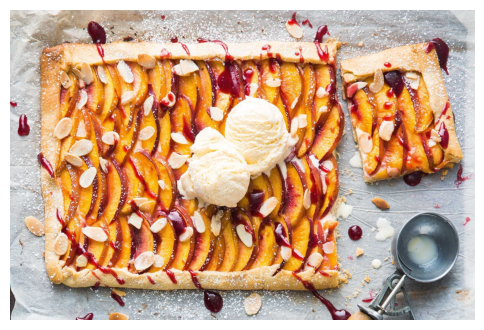

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Top 5 COCO-80 predictions:
  person               100.00%
  car                   33.28%
  motorcycle             0.02%
  dining table           0.01%
  horse                  0.00%

Top 5 Food-101 predictions:
  hot_dog               51.37%
  cannoli               44.81%
  chicken_curry          1.20%
  waffles                0.73%
  foie_gras              0.56%


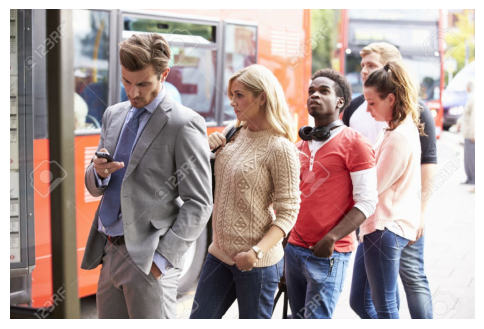

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Top 5 COCO-80 predictions:
  person               100.00%
  backpack              25.62%
  book                   0.94%
  bottle                 0.09%
  train                  0.00%

Top 5 Food-101 predictions:
  ice_cream             91.67%
  churros                4.18%
  gnocchi                2.11%
  chocolate_cake         1.53%
  cup_cakes              0.15%


In [12]:
import tensorflow as tf
import numpy as np
from PIL import Image
import requests
from io import BytesIO

# ─── Model loading & prediction ────────────────────────────────────────────
def load_multi_model(model_path='multi_output_model.h5'):
    return tf.keras.models.load_model(model_path)

def load_image(image_source):
    """
    Loads an image from a file path or URL, returns a normalized 4D numpy batch.
    """
    if image_source.startswith('http://') or image_source.startswith('https://'):
        resp = requests.get(image_source)
        img  = Image.open(BytesIO(resp.content)).convert('RGB')
    else:
        img  = Image.open(image_source).convert('RGB')
    display_image(img)
    arr = np.array(img).astype('float32') / 255.0
    return np.expand_dims(arr, axis=0)   # shape = (1, H, W, 3)

def predict_and_print(image_source, model, top_k=5):
    batch = load_image(image_source)
    preds1, preds2 = model.predict(batch)
    p1 = preds1[0]   # (80,)
    p2 = preds2[0]   # (101,)

    # get top-k indices
    idxs1 = np.argsort(p1)[::-1][:top_k]
    idxs2 = np.argsort(p2)[::-1][:top_k]

    print(f"\nTop {top_k} COCO-80 predictions:")
    for i in idxs1:
        print(f"  {COCO_CLASSES[i]:<20s} {p1[i]*100:6.2f}%")

    print(f"\nTop {top_k} Food-101 predictions:")
    for i in idxs2:
        print(f"  {FOOD_CLASSES[i]:<20s} {p2[i]*100:6.2f}%")

try:
    model = load_multi_model('multi_output_model.h5')
    # Replace with your local path or any image URL
    test_image = 'https://img.taste.com.au/QpTXo12o/taste/2017/01/free-form-nectarine-tart-with-almond-pastry-120098-1.jpg'
    predict_and_print(test_image, model, top_k=5)

    test_image = 'https://previews.123rf.com/images/stockbroker/stockbroker1408/stockbroker140801261/31019617-queue-of-people-waiting-at-bus-stop.jpg'
    predict_and_print(test_image, model, top_k=5)
except Exception as e:
    print(e)


Top 5 Fusion Predictions:


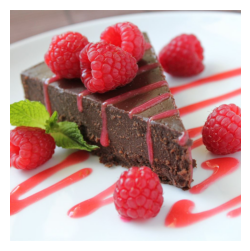

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
chocolate_mousse      87.05%
person                35.95%
remote                25.60%
bottle                19.22%
caprese_salad          7.80%


In [5]:
import tensorflow as tf
import numpy as np
from PIL import Image
import requests
from io import BytesIO

ALL_CLASSES = COCO_CLASSES + FOOD_CLASSES   # length = 181

# ─── 2) BUILD YOUR “181-WAY” FUSION MODEL ────────────────────────────────
# load each head
m80  = tf.keras.models.load_model('model/modelPhase2.h5')   # outputs shape=(batch,80)
m101 = tf.keras.models.load_model('model/modelPhase3.h5')   # outputs shape=(batch,101)

# shared input
inp = tf.keras.Input(shape=(None, None, 3), name='input_image')

# branch 1 → 256×256 → COCO head
b1 = tf.keras.layers.Resizing(256, 256)(inp)
p1 = m80(b1)   # (batch,80)

# branch 2 → 128×128 → Food head
b2 = tf.keras.layers.Resizing(128, 128)(inp)
p2 = m101(b2)  # (batch,101)

# concat into one 181-vector
combined = tf.keras.layers.Concatenate(name='combined_probs')([p1, p2])

# final fusion model
fusion_model = tf.keras.Model(inputs=inp, outputs=combined, name='fusion_181')
# no need to compile if you’re only doing inference
fusion_model.save("modelPhase4.h5")
# ─── 3) INFERENCE + TOP-K PRINTING ───────────────────────────────────────
def load_image(source):
    """Return a (1,H,W,3) float32 batch scaled [0,1]."""
    if source.startswith('http'):
        resp = requests.get(source)
        img  = Image.open(BytesIO(resp.content)).convert('RGB')
    else:
        img  = Image.open(source).convert('RGB')
    display_image(img)
    arr = np.array(img).astype('float32') / 255.0
    return np.expand_dims(arr, 0)

def predict_top_k(source, model, k=5):
    batch = load_image(source)
    preds = model.predict(batch)[0]           # shape = (181,)
    idxs  = np.argsort(preds)[::-1][:k]        # top-k indices
    for i in idxs:
        print(f"{ALL_CLASSES[i]:<20s} {preds[i]*100:6.2f}%")

try:
    test_img1 = 'https://www.allrecipes.com/thmb/WbVx-uv_kT2xUJ9zEISsaJ_I9qE=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/Flourless-Chocolate-Cake-I-by-Dianne-d9d737ee35834921b69ea149ff72dd93.jpg'
    print("\nTop 5 Fusion Predictions:")
    predict_top_k(test_img1, fusion_model, k=5)
except Exception as e:
    print(e)